## Time-series Dataset: Stock Market

Q1 and Q2 of 2011 were particurlarly novel for stock market prediction algorithms. This can be attributed to the markets weathering the volitile era of the Great Recession. In this project, we attempt to take another look at the early 2011 data and classify all the stocks from the Dow Jones Index as a buy or a sell for each following trading week in the quarters. A result of over 0.50 is deemed successful, meaning our model generated profit (based on standardized investment) as it was able to take advantage of buy and sell classifications. Eventually, the model can be put into production by relaying a list of stocks to sell off and purchase for the upcoming week.

I had originally planned to do simple regression on the stock data, but the dataset having weekly samples and being separated by stock meant that binary classification would be a far better task. This was not realize during phase 1 because I did not know about the malperformance of regression with small sample sizes, which is what is dealt with by using this dataset. Furthermore, research was done on the dataset's unique weekly format and a study from "Machine Learning and Data Mining in Pattern Recognition" (Brown) showed that the ideal tasks for such a dataset are clustering and classification. The dataset was provided by Brown and Pelosi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

df = pd.read_csv("dow_jones_index.data", sep=",")

# Preprocessing of data, formatting it so histograms can be displayed
df['open'] = df['open'].str.replace('$', '')
df['high'] = df['high'].str.replace('$', '')
df['low'] = df['low'].str.replace('$', '')
df['close'] = df['close'].str.replace('$', '')
df['next_weeks_open'] = df['next_weeks_open'].str.replace('$', '')
df['next_weeks_close'] = df['next_weeks_close'].str.replace('$', '')

df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['next_weeks_open'] = df['next_weeks_open'].astype(float)
df['next_weeks_close'] = df['next_weeks_close'].astype(float)
df["date"] = df["date"].astype("datetime64")

Above are import statements and a bit of cleaning (convering dollar sign values to float numbers, converting date strings to visually improved datetime values).

### Brief Exploration of Dataset

In [2]:
df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
1,1,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,AA,2011-01-21,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,2011-05-27,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
746,2,XOM,2011-06-03,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
747,2,XOM,2011-06-10,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120
748,2,XOM,2011-06-17,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786


#### The dataset is delineated into 2 quarters with 12 and 13 weeks each Q1 and Q2, respectively. Within each quarter there are 30 stocks. Within each stock, the features for each week are given (taken at the end of the week), along with a feature which states the percent change leading to the following week.

In [3]:
# Number of samples
numsamp = df.shape[0]

# Number of features
numfeat = df.shape[1]

# Number of missing values
missval = df.isnull().sum()

print("Number of samples: ", numsamp)
print("Number of features: ", numfeat)
print(" ")
print("Number of missing values per feature: ")
print(df.isnull().sum())

print(" ")
print("The number of unique values per feature:")
df.date.unique().size
for col in df.columns:
    print(col, "->" ,df[col].unique().size)


Number of samples:  750
Number of features:  16
 
Number of missing values per feature: 
quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64
 
The number of unique values per feature:
quarter -> 2
stock -> 30
date -> 25
open -> 722
high -> 713
low -> 711
close -> 711
volume -> 750
percent_change_price -> 745
percent_change_volume_over_last_wk -> 721
previous_weeks_volume -> 721
ne

Histogram of value vs frequency per feature:


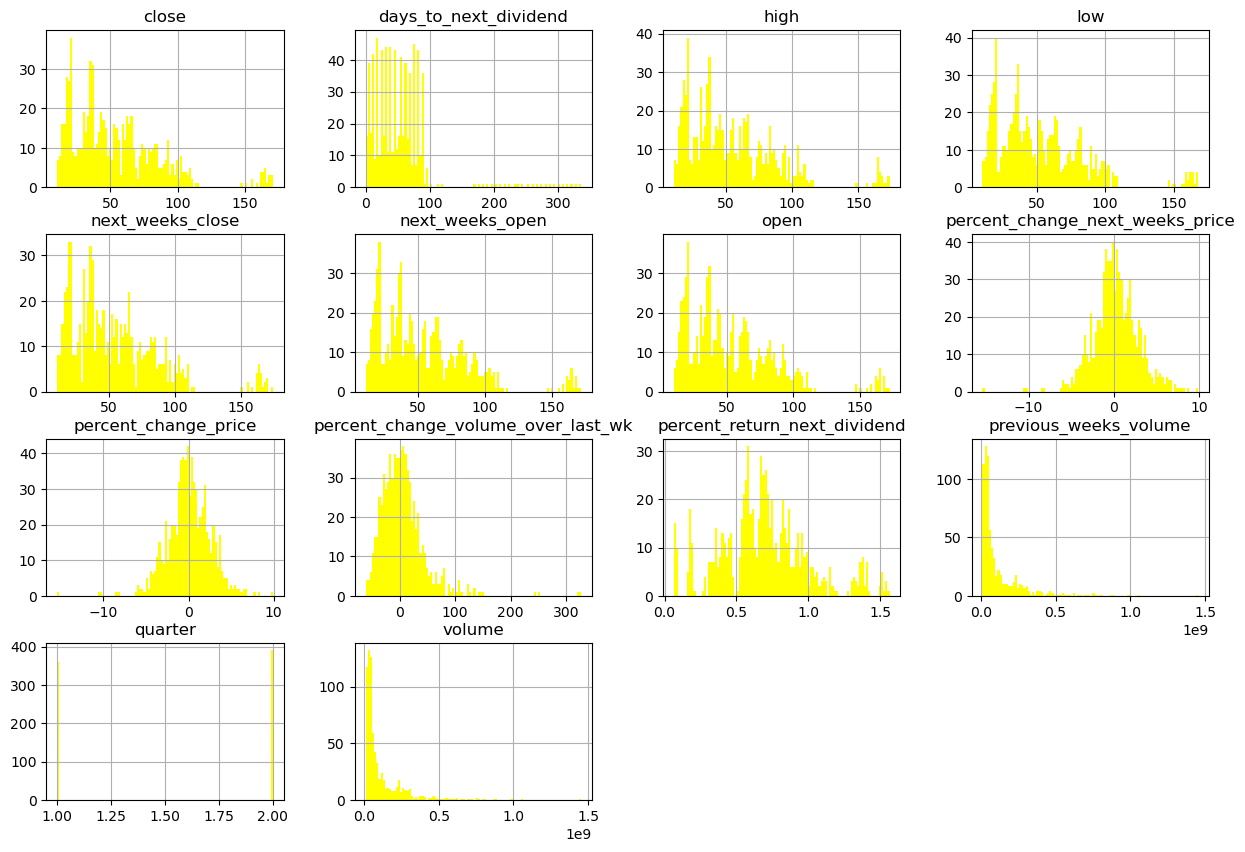

In [4]:
print("Histogram of value vs frequency per feature:")
df.hist(figsize=(15, 10), bins=100, color ="yellow")
plt.show()

#### In the above histograms, the only categorical feature is 'quarter', being either 1 or 2.

Histogram of stock feature, values vs frequency:


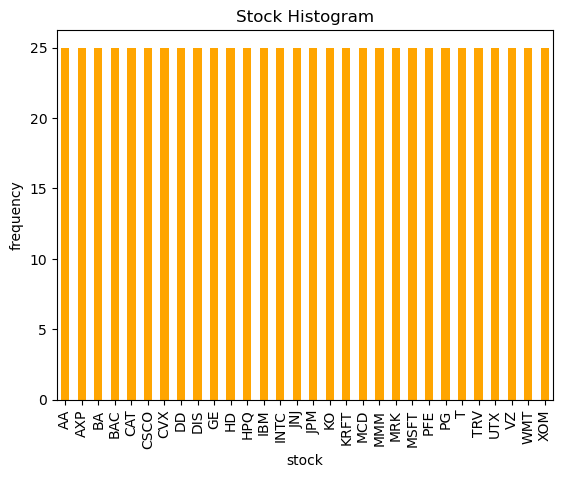

In [5]:
print("Histogram of stock feature, values vs frequency:")
ax = df['quarter'].groupby(df["stock"]).count().plot(kind="bar", color = 'orange', title = "Stock Histogram")
ax.set(xlabel="stock", ylabel="frequency")
plt.show()

#### The 'stock' feature is clearly a categorical feature, with 30 stocks (listed 25 days each)

Histogram of date feature:


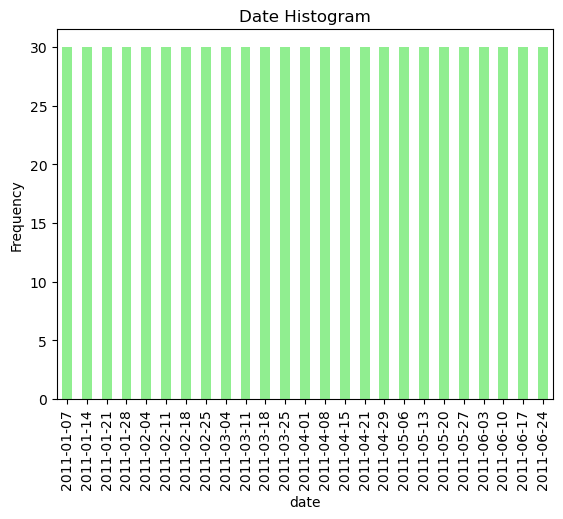

In [6]:
print("Histogram of date feature:")
        
ax = df["stock"].groupby(df["date"].dt.date).count().plot(kind="bar", color ="lightgreen", title="Date Histogram") 
ax.set(xlabel="date", ylabel="Frequency")
plt.show()

#### The date is also categorical, spanning 25 days (with 30 stocks each)

The dataset has 750 samples with 16 features. There are 30 missing values in the columns "percent_change_volume_over_last_wk" and "previous_weeks_volume", because the coresponding data were captured on 1/7/2011, which was the start of the new year, thus the markets were closed the previous week and there is no change from the previous week to report. There are 30 missing values each because there are a total of 30 stocks. Thus, the fraction of missing values is 30/(750*16) = 0.0025. <br /> <br />
The categorical features include: <br />
* quarter (either 1 or 2) 
* stock (one of 30 distinct stocks)
* date (one of 25 distinct dates) 

### Preprocessing

In cell [1], preprocessing was conducted to 
* convert the relavent columns to floats (string dollars to float numbers)
* convert the dates to Python standard dates (string dates to datetimes)



Below, the following preprocessing steps were done:<br />
* Because of the null data in the "percent_change_volume_over_last_wk" and "previous_weeks_volume" features, the first week sample for the first week in each quarter was deleted.
* The date column was changed to reflect the number of days which have passed from the start of the respective quarter to the date.
* A binary categorical classifier was assigned, -1 indicating a sell signal and +1 indicating a buy signal


<!-- </br>
Centering was performed on each column with money values and volume. Percent change remains untouched because it should be the same metric despite the centering. -->



In [7]:
#deleting data for first week of each quarter
df = df[df.date != '2011-01-07']
df = df[df.date != '2011-04-01']
df = df.reset_index()

# replacing days with number of days since start of respective quarter
date_time_str = '01/01/11'
date_time_str2 = '01/04/11'
date_time_obj = datetime.datetime.strptime(date_time_str, '%d/%m/%y')
date_time_obj2 = datetime.datetime.strptime(date_time_str2, '%d/%m/%y')

df.loc[df['quarter'] == 1, 'date'] = (df.loc[df['quarter'] == 1, 'date'] - date_time_obj).dt.days
df.loc[df['quarter'] == 2, 'date'] = (df.loc[df['quarter'] == 2, 'date'] - date_time_obj2).dt.days

df = df.rename(columns={"date":'daysSinceQStart'})

# assigning a binary classifier categorizing the price
df = df.assign(buysell = np.sign(df.percent_change_next_weeks_price))

# df['buysell']=df['buysell'].replace(0,-1)
df['buysell']=df['buysell'].replace(0,0)
df['buysell']=df['buysell'].replace(-1,0)
# .replace(1, with 1) uncecssary

### Feature Selection

The method we have chosen for feature selection is filtering, which is done by creating a correlation heatmap and seeing which features share a greater |correlation| with the 'buysell' classification. We will also compare the correlation heatmap between the features and 'price_change_next_week'. This method is in coordination with ISLR pg. 74 and online resources (Machine Learning Mastery) stating its usefulness in binary classification and limited samples. The method, known as the filter method, was inspired by the Microsoft research citation posted below, and after testing it out it performed better than PCA. We opted for this method over PCA because the number of features is significant when compared to the number of samples for each stock (23), and after doing some research the filter method with Pearson's correlation metric is the best. Pearson's correlation, the most common form of measuring linear correlation, assumes the following formula: $r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$. This will be applied between each feature and the dependent feature to produce a heatmap. Then, we will perform feature selection by selecting the features which had the highest correlation with our dependant variables, checking to see if the highest correlated features remains the same between the preprocessed "percent_change_next_weeks_price" and also the converted "buysell" variables. We care about feature selection over feature learning in this case because we know that much of the quantative data provided is not relavent to the future price change, such as volume and percent change volume. Furthermore, it was advised by the paper listed in citation (by Dr. Yuqinq He) that for stock data, feature selection is used, and we used this to develop our feature selection method.

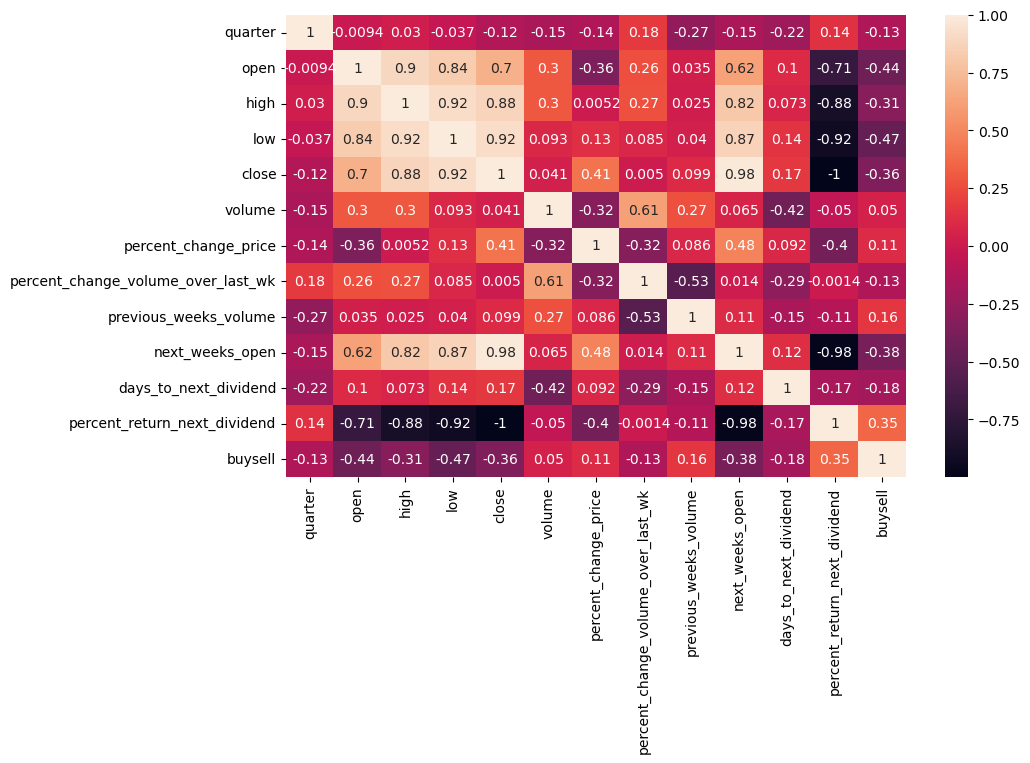

In [8]:
# dividing the data into independent and dependent features
X = df[['quarter','stock','daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
Y = df[['quarter', 'stock', 'next_weeks_close', 'percent_change_next_weeks_price', 'buysell']]
Y = Y[['quarter','stock','buysell']]
X = X[['quarter','stock', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]

# We will use AA stock to perform feature selection
# Feature Selection will be done by first creating a heatmap to observe the correlation
# between the features and the categorical classifier
X_AA = X.loc[X['stock'] == 'AA', ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
Y_AA = Y.loc[Y['stock']=='AA', ['buysell']]
combined = X_AA.assign(buysell = Y_AA)

import seaborn as sns
cor = combined.corr()
plt.figure(figsize = (10,6))
sns.heatmap (cor, annot = True)



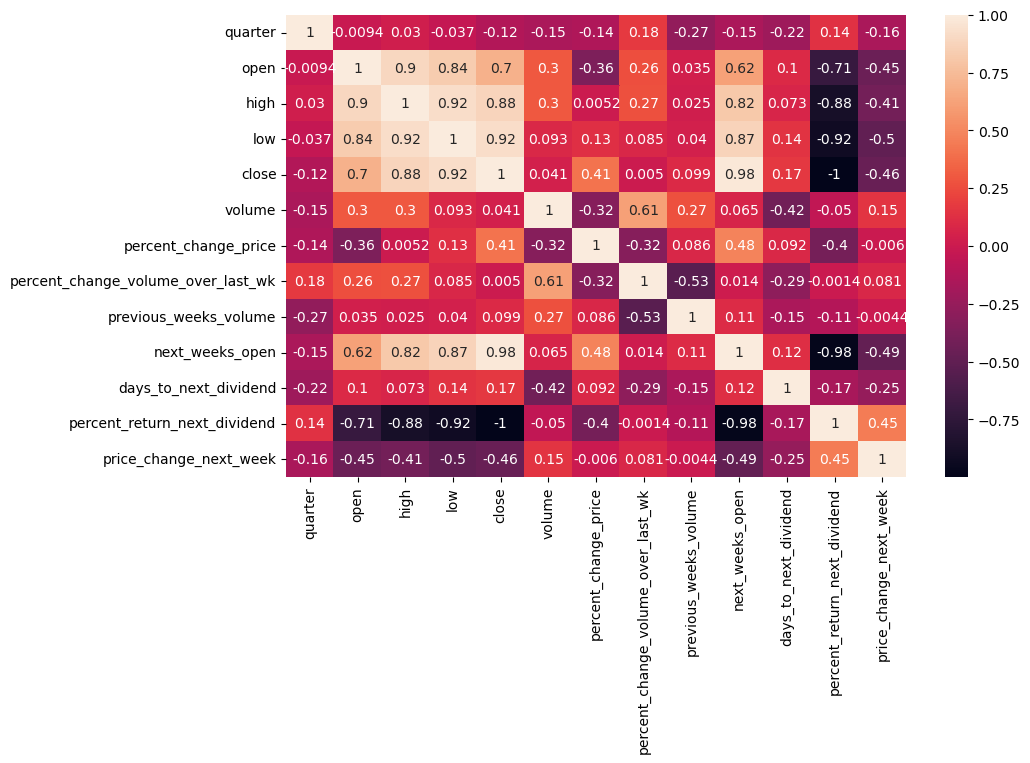

In [9]:
# dividing the data into independent and dependent features
X = df[['quarter','stock','daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
Y = df[['quarter', 'stock', 'next_weeks_close', 'percent_change_next_weeks_price', 'buysell']]
Y = Y[['quarter','stock','buysell', 'percent_change_next_weeks_price']]
X = X[['quarter','stock', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]

# We will use AA stock to perform feature selection
# Feature Selection will be done by first creating a heatmap to observe the correlation
# between the features and the categorical classifier
X_AA = X.loc[X['stock'] == 'AA', ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
Y_AA = Y.loc[Y['stock']=='AA', ['percent_change_next_weeks_price']]
combined = X_AA.assign(price_change_next_week = Y_AA)

import seaborn as sns
cor = combined.corr()
plt.figure(figsize = (10,6))
sns.heatmap (cor, annot = True)

Looking at the correlation heatmaps, and setting a correlation threshold of |0.3|, the most relavent features are:
* open
* high
* low
* close
* next_weeks_open
* percent_return_next_dividend

The other features can be discarded.

### Processing The Dataset

 Now that we have our relavent features, we can perform parameter tuning by cross validation.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

#### Because each stock pattern is different (for each stock ticker), it is imperative that the model is run for each stock indivudially, with the resutls summed together afterwards.

After considering the size of the dataset and the low covariance, the following methods for classification were chosen:
* Logistic regression - this was chosen because the output is categorical, and there are no outliers among each stock
* Ridge classifier - because the market can differ from Q1 and Q2, we wanted to avoid overfitting to any subset of the data. Thus, in accordance with the Medium study cited below, which compares different classification methods, we selected the ridge classifier as to prevent overfitting.
</br>
</br>
The reasoning was justified from the g2 citation.
This will be done by running the model <ins>treating each stock as its own dataset</ins>. The model will be run on each ticker, the dataset being all the relavent features over the quarter = 1 and quarter = 2 for that stock. Then, the metadata (accuracy data) for each stock will be summed to produce a total accuracy over the entire Dow Jones Index.

#### Logistic Regression

Parameter Tuning

Logistic regression uses cross entropy as the loss function. It estimates the probability of a binary outcome, produced by a linear combination of the independent features.</br>

For logistic regression, there were several hyperparameters to tune:
* solver: this was kept standard after comparing each type of solver using CV, and because according to SciKit docs, Limited-memory BFGS optimization performs well with small dataset binary classification
* penalty: because the solver was standard, the available penalty parameters are either none or L2 penalty; testing below shows that among all folds, the model performs best when the penalty is set to the standard L2 penalty
* penalty strength (c): c values within [100, 10, 1.0, 0.1, 0.01] were tested against the above two standards; the c value is the inverse of the regularization parameter, and acts as a penalty for being too well fit to the trining data. It ensures that the model does not completely follow the idiosyncranicies of the training dataset. After testing across multiple folds, the ideal c value was 1.0.

Each was tested against the range of folds to ensure random partitioning. The results of the tests are shown below.

First, let's use penalty L2 and find the best penalty strength value (c):

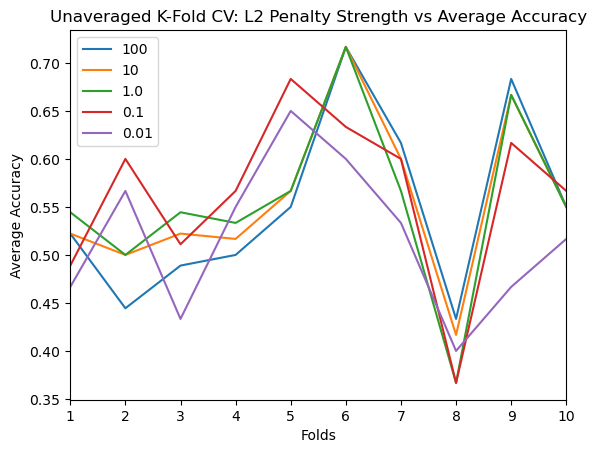

In [11]:
def runModel(ticker, k, c):
    
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)
    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    Y1 = np.array(Y1).ravel()
    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression(C = c)
    acc_score = []
    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)
    avg_acc_score = np.sum(acc_score)/k
    # Accuracy of each fold for stock - (acc_score)
    # Avg accuracy - (avg_acc_score)
    return avg_acc_score, acc_score

lstx1 = []
lsty1 = []

k=10
totsum = []
totfolds = []

for c in [100, 10, 1.0, 0.1, 0.01]:
    sum = 0
    folds= [0]*k
    for element in df['stock'].unique():
        addto, foldslist = runModel(element, k, c)
        sum+= addto
        folds = np.add(folds, foldslist)
    totsum.append(sum)
    totfolds.append(folds/30)

    
plt.title("Unaveraged K-Fold CV: L2 Penalty Strength vs Average Accuracy")
plt.xlabel('Folds')
plt.ylabel('Average Accuracy')
for element in range(len([100, 10, 1.0, 0.1, 0.01])):
    plt.plot(np.linspace(1,k,k), totfolds[element])
plt.legend([100, 10, 1.0, 0.1, 0.01])
plt.xlim(1,10)
plt.show()

Across the unaveraged folds, it is already quite evident that 0.1 is consistently outperforming the other penalties. 

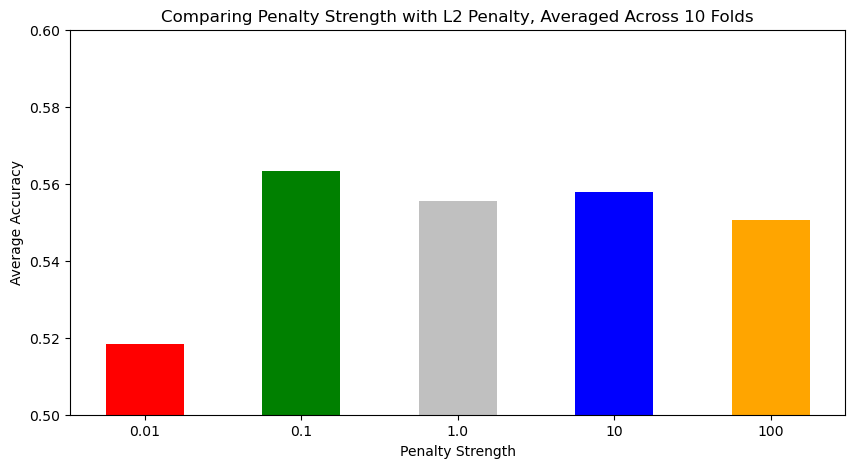

In [12]:
sumlst = []
for element in range(len([100, 10, 1.0, 0.1, 0.01])):
    sumlst.append(totsum[element]/30)
sumlst.reverse()

col = ['red', 'green', 'silver', 'blue', 'orange', 'lightgreen']
fig = plt.figure(figsize = (10, 5))
plt.bar(['0.01', '0.1', '1.0', '10', '100'], sumlst, color =col,
        width = 0.5)
plt.title("Comparing Penalty Strength with L2 Penalty, Averaged Across 10 Folds")
plt.xlabel('Penalty Strength')
plt.ylabel('Average Accuracy')
plt.ylim(0.5,0.6)
plt.show()

The plot shows that 0.1 produces a consistently high average accuracy across all folds. Thus, the best penalty strength value for L2 is c = 1.0. We still have to compare these values to the other penalty option.

The other penalty option would be penalty = 'none'. When there is no penalty equation, then there is no c value to be used. Thus, we would simply compare all the L2 results with the singular no-penalty result:

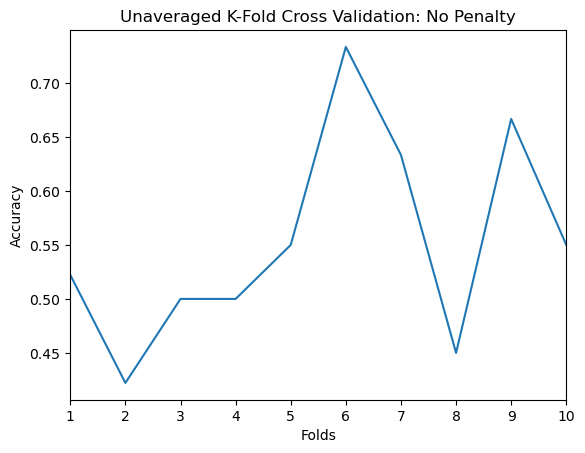

In [13]:
def runModel(ticker, k):
    
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)
    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    Y1 = np.array(Y1).ravel()
    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression(penalty = 'none')
    acc_score = []
    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)
    avg_acc_score = np.sum(acc_score)/k
    # Accuracy of each fold for stock - (acc_score)
    # Avg accuracy - (avg_acc_score)
    return avg_acc_score, acc_score

lstx15 = []
lsty15 = []

k=10
sum = 0
folds= [0]*k
for element in df['stock'].unique():
    addto, foldslist = runModel(element, k)
    sum+= addto
    folds = np.add(folds, foldslist)
lstx15.append(k)
lsty15.append(sum/len(df['stock'].unique()))
data = {'Folds': lstx15, 'Accuracy': lsty15}
logdf15 = pd.DataFrame(data)
plt.plot(np.linspace(1,k,k), folds/30)
plt.title('Unaveraged K-Fold Cross Validation: No Penalty')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.xlim(1,10)
plt.show()


This is a visualization of what the model produced at each fold increment. It follows a similar pattern to the L2 penalty, rising in accuracy at 5 folds and falling to a min at 8 folds. The averaged value is placed in the bar chart below.

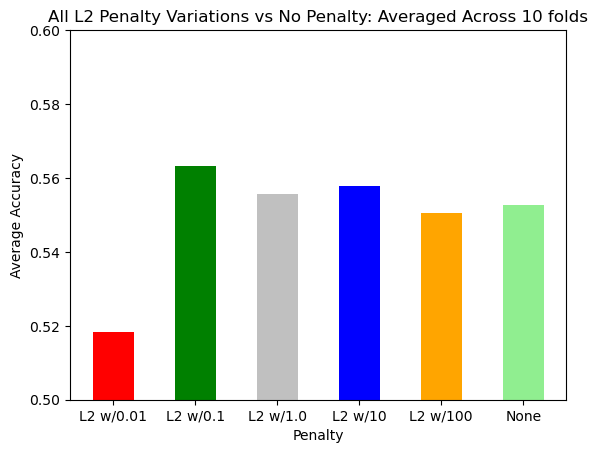

In [14]:
sumlst.append((folds/30).sum()/10)
plt.bar(['L2 w/0.01', 'L2 w/0.1', 'L2 w/1.0', 'L2 w/10', 'L2 w/100', 'None'], sumlst, color =col,
        width = 0.5)
plt.title("All L2 Penalty Variations vs No Penalty: Averaged Across 10 folds")
plt.xlabel('Penalty')
plt.ylabel('Average Accuracy')
plt.ylim(0.5,0.6)
plt.show()


L2 w/0.01 seems to outperform the other hyperparameter combinations.

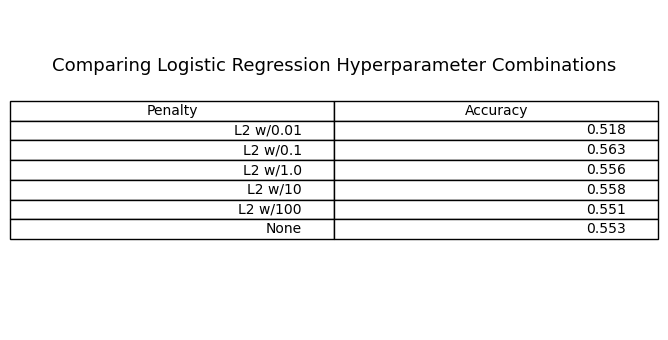

In [15]:
sumlstdf = pd.DataFrame(np.transpose(['L2 w/0.01', 'L2 w/0.1', 'L2 w/1.0', 'L2 w/10', 'L2 w/100', 'None']))
sumlstdf['A'] = np.transpose([sumlst])
sumlstdf['A'] = sumlstdf['A'].round(3)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.random.random((10, 3))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=sumlstdf.values, colLabels=['Penalty', 'Accuracy'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
plt.title("Comparing Logistic Regression Hyperparameter Combinations", fontsize=13, y=0.8, pad=2)
plt.show()

From the graph above, we can see that L2, c = 0.1 produces greater accuracy across more folds, thus we can finalize our penalty to be L2, meaning that the square of the magnitude of the coefficients is added as the penalty, and strength to be 0.1. The strength being low means that the model is not as constrained as it is at higher values.

#### CV With Finalized Parameters

* solver = standard lbfgs
* penalty = L2
* penalty strength = 0.1

#### Sidenote:
It is important to note that on some of the stocks, the model was much more accurate. When we did further research, we found that this was observed in stocks with a single trajectory, like banks, which did not perform well in 2011, and thus had a constant freefall trajectory. For example, the logistic regression model had an average accuracy of 0.8 when conducted across 10 folds for the Bank of America stock:

In [16]:
# Linear Regression, cv for Bank of America alone
X_AA = X.loc[X['stock'] == 'BAC', ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
Y_AA = Y.loc[Y['stock']== 'BAC', ['buysell']]
combined = X_AA.assign(buysell = Y_AA)


X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
Y1 = combined[['buysell']]

Y1 = np.array(Y1).ravel()
k=10
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(C=0.1)

acc_score = []

for train_index , test_index in kf.split(X1):
    X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
    y_train , y_test = Y1[train_index] , Y1[test_index]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
        
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)

avg_acc_score = np.sum(acc_score)/k

print('Avg accuracy for BAC: {}'.format(avg_acc_score))


Avg accuracy for BAC: 0.8


#### Ridge Classifier

Parameter tuning

Ridge regression, which is a penalized version of linear regression, gives rise to the ridge classifier. It works by adding a penalty to the cost function. The penalty is calculated by summing the squared coefficients of each independent feature. Thus, the coefficents are encouraged to stay small, preventing overfitting. <br/>
<br/>
It is minimizes the function $||y - Xw||^2_2 + alpha * ||w||^2_2$

<br/>

The main hyperparameter with ridge classification is:
* alpha: This is the parameter which describes how much the model should prevent overfitting. We will take it to be within the range [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0].

Before starting ridge classifier we have to code the variables to +1 or -1. In our model, +1 will represent 'buy' and -1 will represent 'sell'

In [17]:
Y['buysell']=Y['buysell'].replace(0,-1)

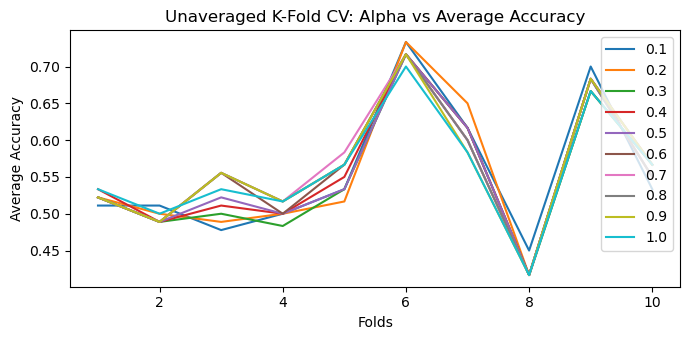

In [18]:
def runModel(ticker, k, a):
    
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)
    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    Y1 = np.array(Y1).ravel()
    kf = KFold(n_splits=k, random_state=None)
    model = RidgeClassifier(alpha = a)
    acc_score = []
    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)
    avg_acc_score = np.sum(acc_score)/k
    # Accuracy of each fold for stock - (acc_score)
    # Avg accuracy - (avg_acc_score)
    return avg_acc_score, acc_score

lstx3 = []
lsty3 = []

k=10
totsum = []
totfolds = []

for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    sum = 0
    folds= [0]*k
    for element in df['stock'].unique():
        addto, foldslist = runModel(element, k, a)
        sum+= addto
        folds = np.add(folds, foldslist)
    totsum.append(sum)
    totfolds.append(folds/30)

    
plt.title("Unaveraged K-Fold CV: Alpha vs Average Accuracy")
plt.xlabel('Folds')
plt.ylabel('Average Accuracy')
for element in range(len([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])):
    plt.plot(np.linspace(1,k,k), totfolds[element])
plt.legend([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

This is the unaveraged plot for the ridge classifier. It follows a similar shape to the logistic regression plot. We will now average the results and compare performance.

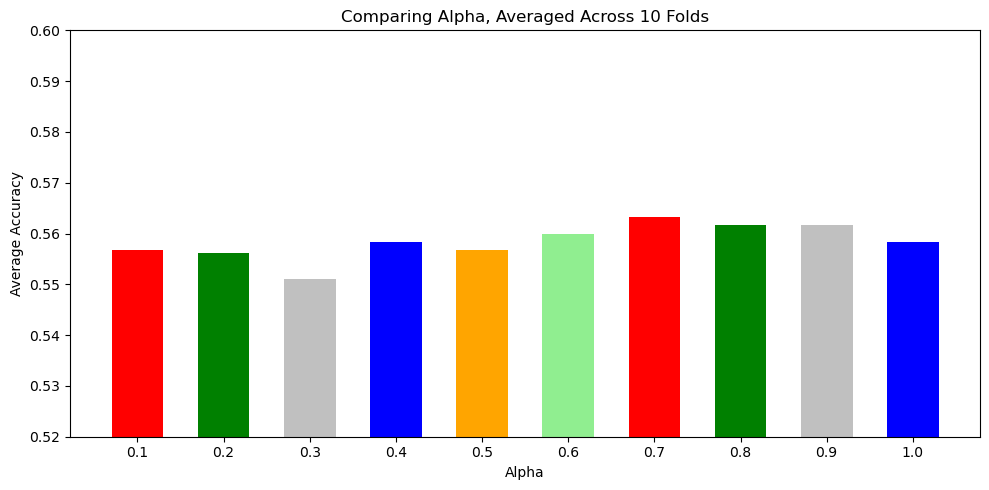

In [19]:
sumlst = []
for element in range(len([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])):
    sumlst.append(totsum[element]/30)

col = ['red', 'green', 'silver', 'blue', 'orange', 'lightgreen']
fig = plt.figure(figsize = (10, 5))
plt.bar([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], sumlst, color =col,
        width = 0.06)
plt.title("Comparing Alpha, Averaged Across 10 Folds")
plt.xlabel('Alpha')
plt.ylabel('Average Accuracy')
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim(0.52,0.6)
plt.show()

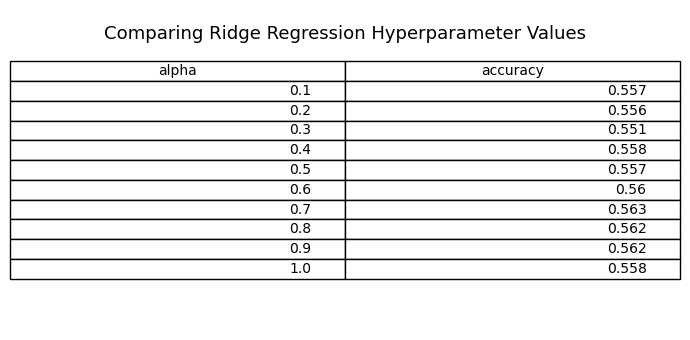

In [20]:
sumlstdf = pd.DataFrame(np.transpose([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
sumlstdf['A'] = np.transpose([sumlst])
sumlstdf['A'] = sumlstdf['A'].round(3)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
data = np.random.random((10, 3))
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=sumlstdf.values, colLabels=['alpha', 'accuracy'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
plt.title("Comparing Ridge Regression Hyperparameter Values", fontsize=13, y=0.9, pad=2)
plt.show()


The data show that alpha = 0.7 consistently outperforms all other alpha values. This means that averaged across all folds, when 0.7 is added to the cost function, the model produces greatest accuracy.

#### CV With Finalized Parameters
* alpha = 0.7

### Comparative analysis of the two methods on each dataset

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
def runModel(ticker, k):
    global conlog
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)
    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    Y1 = np.array(Y1).ravel()
    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression(C=0.1)
    acc_score = []
    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        conlog+=cm
        #print(cm)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = np.sum(acc_score)/k

    #print('accuracy of each fold - {}'.format(acc_score))
    #print('Avg accuracy : {}'.format(avg_acc_score))
    return avg_acc_score

lstx15 = []
lsty15 = []

k=10
sum = 0
folds= [0]*k
lstx10 = []
lsty10 = []
conlog = []
conlog.append([[0,0],[0,0]])
sum=0
for element in df['stock'].unique():
    sum+= runModel(element, 4)
lstx10.append(4)
lsty10.append(sum/len(df['stock'].unique()))
#print(k, "|",  sum/len(df['stock'].unique()))
    
data = {'Folds': lstx10, 'Average Accuracy': lsty10}
logdf10 = pd.DataFrame(data)

In [23]:
def runModel(ticker, k):
    global conrid
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)
    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    Y1 = np.array(Y1).ravel()
    kf = KFold(n_splits=k, random_state=None)
    model = RidgeClassifier(alpha=0.7)
    acc_score = []
    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        conrid+=cm
        #print(cm)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = np.sum(acc_score)/k

    #print('accuracy of each fold - {}'.format(acc_score))
    #print('Avg accuracy : {}'.format(avg_acc_score))
    return avg_acc_score

lstx15 = []
lsty15 = []

k=10
sum = 0
folds= [0]*k
lstx10 = []
lsty10 = []
conrid = []
conrid.append([[0,0],[0,0]])
sum=0
for element in df['stock'].unique():
    sum+= runModel(element, 4)
lstx10.append(4)
lsty10.append(sum/len(df['stock'].unique()))
#print(k, "|",  sum/len(df['stock'].unique()))
    
data = {'Folds': lstx10, 'Average Accuracy': lsty10}
logdf10 = pd.DataFrame(data)

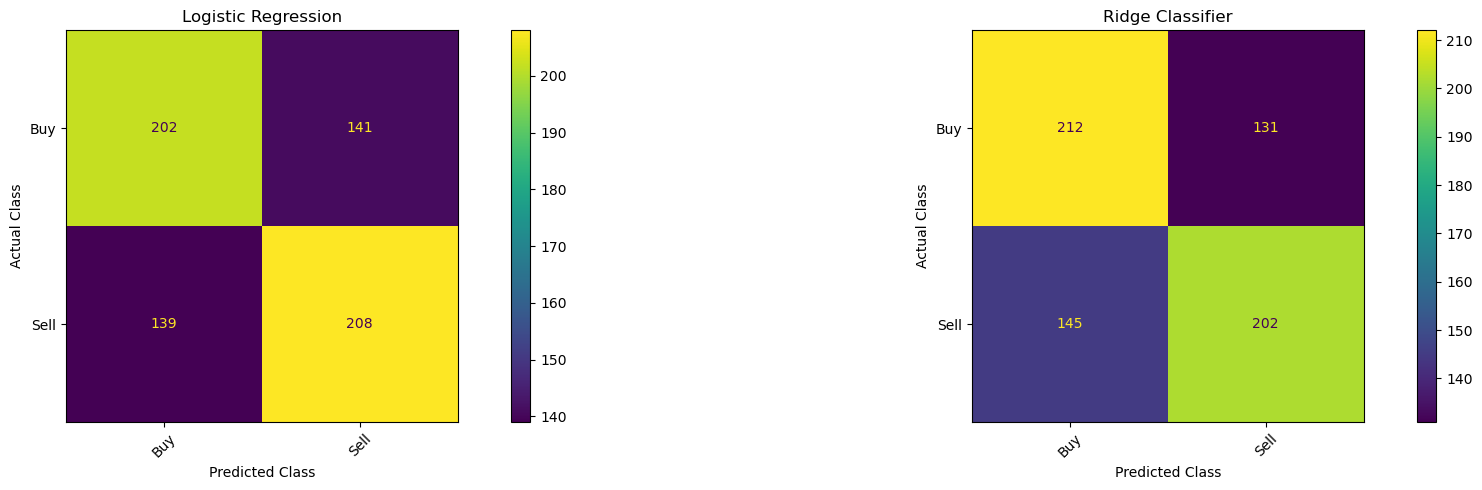

In [24]:
from sklearn import metrics
cm1_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conlog[0], display_labels = ['Buy', 'Sell'])
cm2_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conrid[0], display_labels = ['Buy', 'Sell'])
f, axes = plt.subplots(1, 2, figsize=(20, 5))


cm1_display.plot(ax=axes[0], xticks_rotation=45)
cm2_display.plot(ax=axes[1], xticks_rotation=45)

cm1_display.ax_.set(xlabel='Predicted Class', ylabel='Actual Class', title="Logistic Regression")
cm2_display.ax_.set(xlabel='Predicted Class', ylabel='Actual Class', title="Ridge Classifier")

plt.show()

By the ordering of the confusion matrices, these are the results:
* Logistic Regresion: $TP = 202, FN = 141, FP = 139, TN = 208$
* Ridge Classifier: $TP = 212, FN = 131, FP = 145, TN = 202$</br>


Accuracy = (TP+TN) / (TP+FP+TN+FN) </br>
</br>
Logistic Regression Accuracy: $0.594$ </br>
Ridge Classifier Accuracy: $0.600$

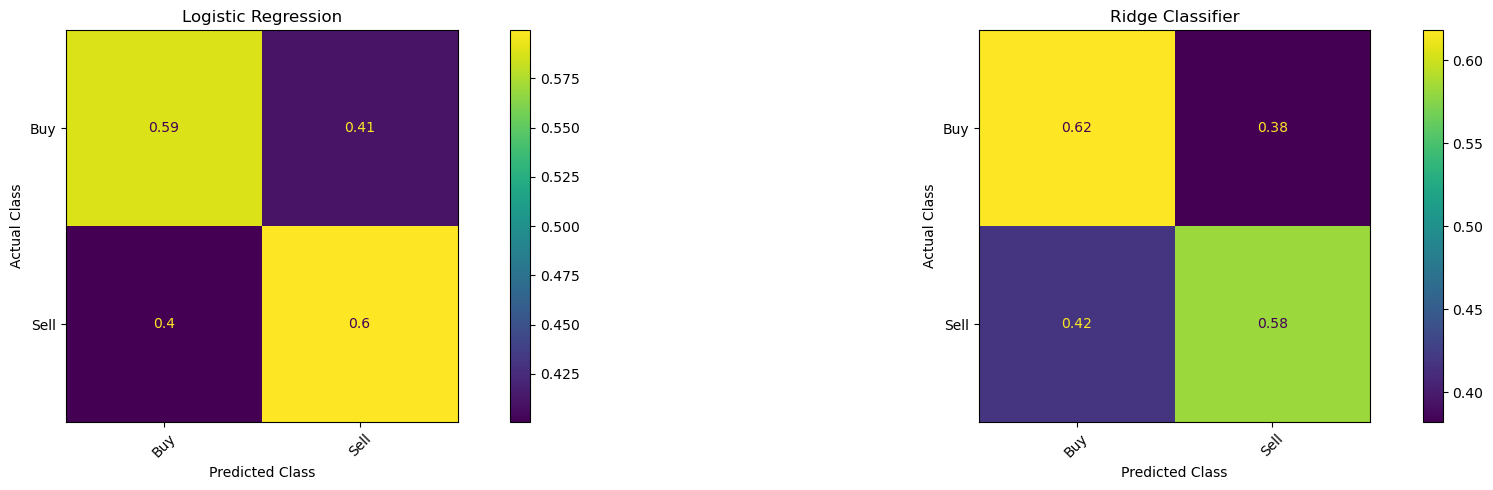

In [25]:
row1 = conlog[0][0,:]/np.sum(conlog[0][0,:])
row2 = conlog[0][1,:]/np.sum(conlog[0][1,:])
f = np.array([row1.tolist(), row2.tolist()])
a = (metrics.ConfusionMatrixDisplay(confusion_matrix = f, display_labels = ['Buy', 'Sell']))


row3 = conrid[0][0,:]/np.sum(conrid[0][0,:])
row4 = conrid[0][1,:]/np.sum(conrid[0][1,:])
s = np.array([row3.tolist(), row4.tolist()])
b = (metrics.ConfusionMatrixDisplay(confusion_matrix = s, display_labels = ['Buy', 'Sell']))


f, axes = plt.subplots(1, 2, figsize=(20, 5))


a.plot(ax=axes[0], xticks_rotation=45)
b.plot(ax=axes[1], xticks_rotation=45)

a.ax_.set(xlabel='Predicted Class', ylabel='Actual Class', title="Logistic Regression")
b.ax_.set(xlabel='Predicted Class', ylabel='Actual Class', title="Ridge Classifier")

plt.show()

By the ordering of the standardized confusion matrices, these are the results:
* Logistic Regresion: $TPR = 0.59, FNR = 0.41, FPR = 0.4, TNR = 0.6$
* Ridge Classifier: $TPR = 0.62, FNR = 0.38, FPR = 0.42, TNR = 0.58$</br>

Precision = (TP)/(TP+FP) </br>

* Logistic Regression: Precision = 0.592, Recall = 0.59, F-1 Score = 0.591
* Ridge Classfier: Precision = 0.593, Recall = 0.62, F-1 Score = 0.606
</br>

RidgeClassifier was more accurate in general. However, when applying the model to stock data, FPR and TPR values are of most importance. FPR is important because you do not want to purchase stock which is about to incur a loss, on the false pretense that it is profitable (false buy signal). TPR is important because we are trying to maximize profit and thus want to capture as much correctly predicted buy signals as possible. In our model, the FPR advantage that Logistic Regression has is superseded by the TPR of the Ridge Classifier.

##### Measuring processing time:

In [26]:
from sklearn.metrics import confusion_matrix
import time

def runModel(ticker, k):
    global conlog
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)


    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    #X1 = combined[['open', 'low', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    
    Y1 = np.array(Y1).ravel()

    kf = KFold(n_splits=k, random_state=None)
    model = LogisticRegression(C = 0.1)

    acc_score = []

    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        conlog+=cm
        #print(cm)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = np.sum(acc_score)/k

    #print('accuracy of each fold - {}'.format(acc_score))
    #print('Avg accuracy : {}'.format(avg_acc_score))
    return avg_acc_score




timeslog = []

for i in range(100):
    start = time.time()
    lstx10 = []
    lsty10 = []
    conlog = []
    conlog.append([[0,0],[0,0]])
    sum=0
    for element in df['stock'].unique():
        sum+= runModel(element, 10)
    lstx10.append(4)
    lsty10.append(sum/len(df['stock'].unique()))
    #print(k, "|",  sum/len(df['stock'].unique()))

    data = {'Folds': lstx10, 'Average Accuracy': lsty10}
    logdf10 = pd.DataFrame(data)
    end = time.time()
    timeslog.append(end - start)


In [27]:
from sklearn.metrics import confusion_matrix
def runModel(ticker, k):
    global conlog
    X_AA = X.loc[X['stock'] == ticker, ['quarter', 'daysSinceQStart', 'open', 'high', 'low', 'close', 'volume', 'percent_change_price', 'percent_change_volume_over_last_wk', 'previous_weeks_volume', 'next_weeks_open', 'days_to_next_dividend', 'percent_return_next_dividend']]
    Y_AA = Y.loc[Y['stock']== ticker, ['buysell']]
    combined = X_AA.assign(buysell = Y_AA)


    X1 = combined[['open', 'high', 'low', 'close', 'next_weeks_open', 'percent_return_next_dividend']]
    Y1 = combined[['buysell']]
    
    Y1 = np.array(Y1).ravel()

    kf = KFold(n_splits=k, random_state=None)
    model = RidgeClassifier(alpha=0.7)

    acc_score = []

    for train_index , test_index in kf.split(X1):
        X_train , X_test = X1.iloc[train_index,:],X1.iloc[test_index,:]
        y_train , y_test = Y1[train_index] , Y1[test_index]
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
        
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        cm = confusion_matrix(y_test, pred_values)
        conlog+=cm
        #print(cm)
        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = np.sum(acc_score)/k

    #print('accuracy of each fold - {}'.format(acc_score))
    #print('Avg accuracy : {}'.format(avg_acc_score))
    return avg_acc_score




timesrid = []

for i in range(100):
    start = time.time()
    lstx10 = []
    lsty10 = []
    conlog = []
    conlog.append([[0,0],[0,0]])
    sum=0
    for element in df['stock'].unique():
        sum+= runModel(element, 10)
    lstx10.append(4)
    lsty10.append(sum/len(df['stock'].unique()))
    data = {'Folds': lstx10, 'Average Accuracy': lsty10}
    logdf10 = pd.DataFrame(data)
    end = time.time()
    timesrid.append(end - start)


The models were run 100 times each and the time it took to produce a prediction was averaged.

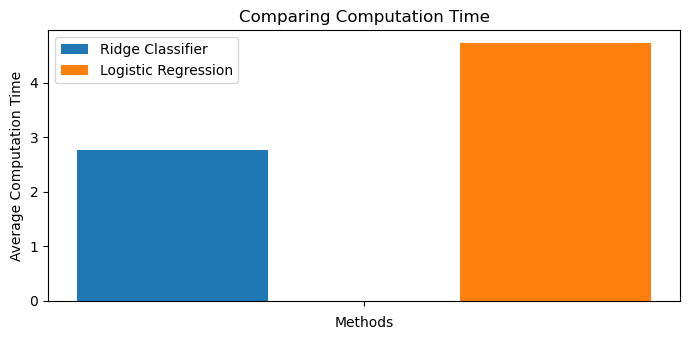

Ridge Classifier time:  2.775017738342285
Logistic Regression time:  4.730757176876068


In [28]:
X = ['']
Ygirls = [np.mean(timesrid)]
Zboys = [np.mean(timeslog)]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.2, label = 'Ridge Classifier')
plt.bar(X_axis + 0.2, Zboys, 0.2, label = 'Logistic Regression')
  
plt.xticks(X_axis, X)
plt.xlabel("Methods")
plt.ylabel("Average Computation Time")
plt.title("Comparing Computation Time")
plt.legend()
plt.show()

print("Ridge Classifier time: ",np.mean(timesrid))
print("Logistic Regression time: ",np.mean(timeslog))

The results show that the ridge classifier was $15.5$% faster. This is mainly because it only requires the solution of a single set of linear equations, while the logistic regression classifier uses iterative reweighted least squares. This requires the repetitive solving of linear equations (Minka 2003).

Overall, based on our findings, we would recommend ridge classifier. It produces better relavent accuracy and it identifies more buy signals. While logistic regression has the advantage in identifying sell signals (evidenced by its higher TNR), the ridge classifier's TPR is 4.8% greater and the FNR is 7.9% lower. This maximizes the identification of buy signals. It is also much faster, leading the way for potential scaling to perform on infinitesimal data increments. Instead of weekly data, by capitalizing on the ridge classifier's speed, users can use the model second by second throughout the day and act accordingly.

### Ethical Issues
* Overreliance on ML model might create chain effect on stocks. Say the model tells investors to sell a particular ticker. If individuals sell, the model will be updated to reflect the sell, and metrics such as price will decrease due to supply increase. The sell classification will be further bolstered, and it becomes a recursive sell event if stops are not put into place.
* This model is prone to bias. Its exploitation by hedge funds could lead to manipulation, generating losses for retail investors. This violates the issue of fairness and also capitalizes on an imbalance of due dilligence of a large hedge fund with connections vs. the average investor.
* Another major ethical principal this model may eventually violate is privacy. In order to introduce more relavent features, brokrages may begin collecting private data (via their mobile applications) to observe interests, habits, and conversations the individual is having with their friends. Left unpunished, brokers may monitor such activity to collect valuable information on people's sentiment towards a certain company or stock ticker and introduce this into the model. This violates right to privacy.
* An ethical good that this model has is that it may actually level the playing field for retail investors who continue to maintain and update the model and know how to interpret the results.

Ethical principles sourced from W3 Group

##### Sidenote
The poor relationship between the market metrics and profitability can clearly be seen in the feature relationship matrix, where the 'buysell' category does not have any covariance over 0.5. In fact, it was so substandard that it drove the push to use Twitter sentiment analysis as a metric for general market prognosis. For the future, we would implement Twitter data into our research. We would also make more attempts to gather more data by purchasing it from a stock dataset dealer rather than rely on minimized data from other research.

### Bibliography
* https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
        
* Brown, M. S., Pelosi, M. & Dirska, H. (2013). Dynamic-radius Species-conserving Genetic Algorithm for the Financial Forecasting of Dow Jones Index Stocks. Machine Learning and Data Mining in Pattern Recognition, 7988, 27-41.

* https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/filter-based-feature-selection

* He, Y., Fataliyev, K., Wang, L. (2013). Feature Selection for Stock Market Analysis. In: Lee, M., Hirose, A., Hou, ZG., Kil, R.M. (eds) Neural Information Processing. ICONIP 2013. Lecture Notes in Computer Science, vol 8227. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-42042-9_91

* https://learn.g2.com/logistic-regression

* https://tminka.github.io/papers/logreg/minka-logreg.pdf
* https://www.w3.org/TR/webmachinelearning-ethics/#accuracy